<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Book_Recommendation_System_gilbert_tanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book Recommendation System

In [0]:
from fastai.collab import *

In [20]:
!ls

books.csv      models	    sample_book.xml  tags.csv
book_tags.csv  ratings.csv  sample_data      to_read.csv


In [21]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [0]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='book_id', rating_name='rating')

In [23]:
data.show_batch()

user_id,book_id,target
14151,4805,5.0
39195,8428,5.0
19337,9468,4.0
24049,9486,4.0
15186,9761,3.0


In [24]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

## EmbeddingDotBias Model

In [0]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")

In [26]:
print(learn.summary())
# This gives us User Embeddings, Item EMbeddings, User Bias, and Item Bias

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [40]                 2,134,040  True      
______________________________________________________________________
Embedding            [40]                 400,040    True      
______________________________________________________________________
Embedding            [1]                  53,351     True      
______________________________________________________________________
Embedding            [1]                  10,001     True      
______________________________________________________________________

Total params: 2,597,432
Total trainable params: 2,597,432
Total non-trainable params: 0



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


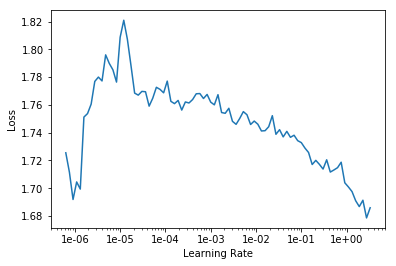

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,time
0,1.583123,1.589371,02:25
1,1.304582,1.316817,02:27
2,1.115972,1.128306,02:29
3,1.014943,1.062750,02:28
4,1.012767,1.053232,02:30


In [0]:
learn.save('goodbooks-dot-1')

## EmbeddingNN Model

In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


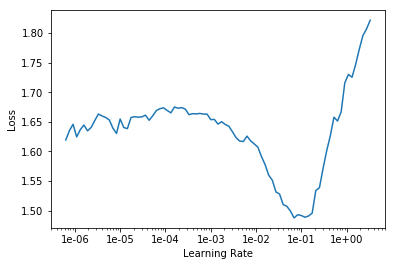

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.790592,0.761457,03:09
1,0.734126,0.739896,03:10
2,0.707992,0.725724,03:03
3,0.672949,0.705706,02:59
4,0.618984,0.718394,02:59


In [0]:
learn.save('goodbooks-nn-1')

## Interpretation

In [0]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('goodbooks-dot-1');

In [36]:
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [37]:
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)
top_books[:10]

array(['5000', '3315', '3313', '3312', '3311', '3309', '3308', '3307', '3306', '3304'], dtype='<U21')

In [0]:
top_books_with_name = []
for book in top_books:
    top_books_with_name.append(books[(books['book_id']==int(book))]['title'].iloc[0])
top_books_with_name = np.array(top_books_with_name)
top_books_with_name

## Book Bias

In [39]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53351, 40)
  (i_weight): Embedding(10001, 40)
  (u_bias): Embedding(53351, 1)
  (i_bias): Embedding(10001, 1)
)

In [0]:
book_bias = learn.bias(top_books, is_item=True)

In [0]:
mean_ratings = ratings.groupby('book_id')['rating'].mean()
book_ratings = [(b, top_books_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_books, book_bias))]

In [0]:
item0 = lambda o:o[0]

In [0]:
sorted(book_ratings, key=item0)[:15]

In [0]:
sorted(book_ratings, key=item0, reverse=True)[:15]

In [46]:
book_w = learn.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 40])

In [47]:
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books_with_name)]

In [49]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[]

In [50]:
sorted(book_comp, key=itemgetter(0))[:10]

[]

In [0]:
book_comp = [(f, i) for f,i in zip(fac1, top_books_with_name)]

In [52]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[]

In [53]:
sorted(book_comp, key=itemgetter(0))[:10]

[]

In [0]:
idxs = np.random.choice(len(top_books_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()